In [24]:
import pandas as pd
import matplotlib.pyplot as plt

dtypes = {
    'row_id': 'int32',
    'timestamp': 'int64',
    'user_id': 'int32',
    'content_id': 'int16',
    'content_type_id': 'int8',
    'task_container_id': 'int16',
    'user_answer': 'int8',
    'answered_correctly': 'int8',
    'prior_question_elapsed_time': 'float32',
    'prior_question_had_explanation': 'boolean'
}

def read_data():
    train = pd.read_csv('train.csv', dtype=dtypes, nrows=50000000)
    questions = pd.read_csv('questions.csv')
    lectures = pd.read_csv('lectures.csv')
    return train, questions, lectures

train, questions, lectures = read_data()

display(train.head())
display(questions.head())
display(lectures.head())


,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


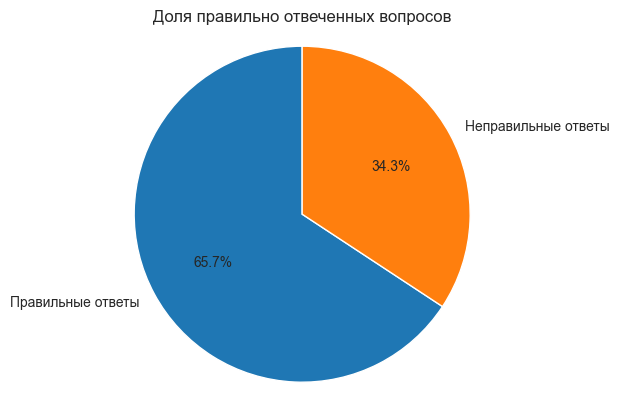

In [25]:
# Фильтрация только вопросов
questions_only = train[train['content_type_id'] == 0]

# Вычисление доли правильных ответов
correct_answer_rate = questions_only['answered_correctly'].mean()

# Визуализация доли правильных ответов
labels = ['Правильные ответы', 'Неправильные ответы']
sizes = [correct_answer_rate, 1 - correct_answer_rate]
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')
plt.title('Доля правильно отвеченных вопросов')
plt.show()

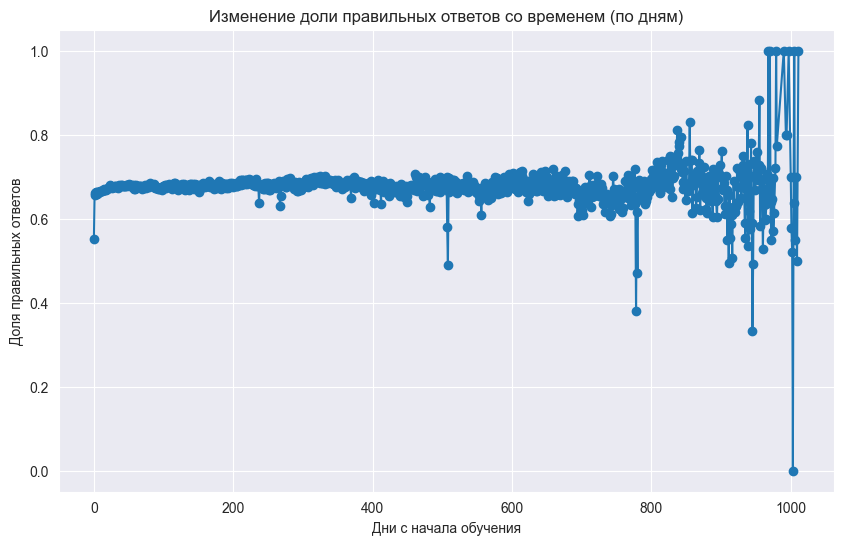

In [26]:
# Фильтрация только вопросов
questions_only = train[train['content_type_id'] == 0].copy()

# Преобразуем timestamp из миллисекунд в дни
questions_only.loc[:, 'days_since_start'] = (questions_only['timestamp'] - questions_only['timestamp'].min()) / (1000 * 60 * 60 * 24)

# Округлим количество дней до целого
questions_only.loc[:, 'days_since_start'] = questions_only['days_since_start'].astype(int)

# Группировка данных по дням и вычисление доли правильных ответов в каждом дне
performance_over_time = questions_only.groupby('days_since_start')['answered_correctly'].mean()

# Построение графика изменения успеваемости со временем
plt.figure(figsize=(10, 6))
plt.plot(performance_over_time.index, performance_over_time.values, marker='o')
plt.title('Изменение доли правильных ответов со временем (по дням)')
plt.xlabel('Дни с начала обучения')
plt.ylabel('Доля правильных ответов')
plt.grid(True)
plt.show()

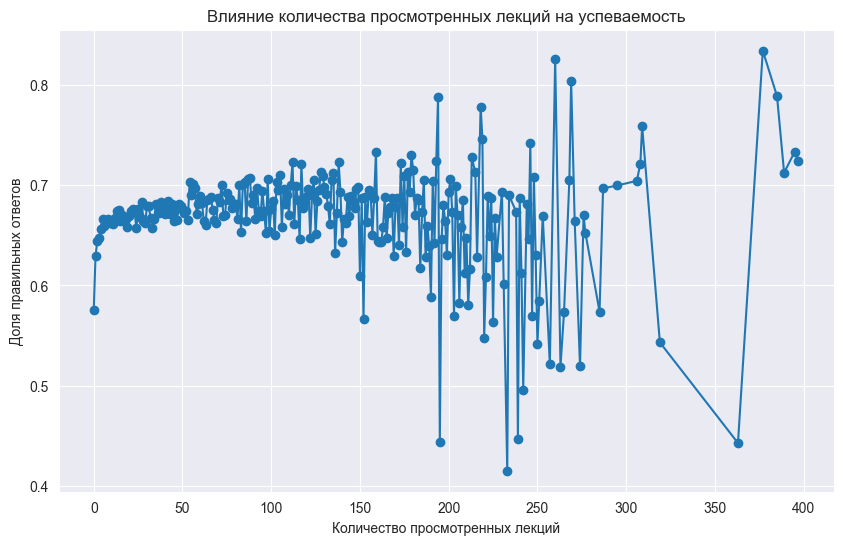

In [27]:

# 1. Фильтрация данных: отделим лекции и вопросы
lectures_only = train[train['content_type_id'] == 1]
questions_only = train[train['content_type_id'] == 0]

# 2. Подсчёт количества просмотренных лекций для каждого пользователя
lectures_per_user = lectures_only.groupby('user_id').size().reset_index(name='lecture_count')

# 3. Добавляем количество просмотренных лекций к данным с вопросами
questions_with_lecture_count = pd.merge(questions_only, lectures_per_user, on='user_id', how='left')

# Заполняем пропуски (где пользователи не смотрели лекции) значением 0
questions_with_lecture_count['lecture_count'] = questions_with_lecture_count['lecture_count'].fillna(0)

# 4. Группировка по количеству просмотренных лекций и расчёт средней доли правильных ответов
performance_by_lecture_count = questions_with_lecture_count.groupby('lecture_count')['answered_correctly'].mean()

# 5. Построение графика зависимости успеваемости от количества просмотренных лекций
plt.figure(figsize=(10, 6))
plt.plot(performance_by_lecture_count.index, performance_by_lecture_count.values, marker='o')
plt.title('Влияние количества просмотренных лекций на успеваемость')
plt.xlabel('Количество просмотренных лекций')
plt.ylabel('Доля правильных ответов')
plt.grid(True)
plt.show()

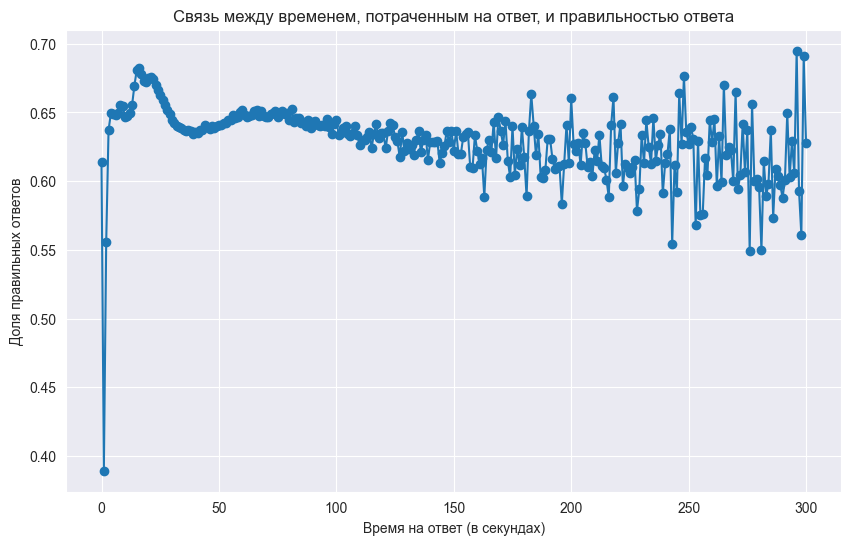

In [28]:
# 1. Фильтрация данных: оставляем только вопросы
questions_only = train[train['content_type_id'] == 0]

# 2. Отфильтруем строки с пропусками в prior_question_elapsed_time
filtered_questions = questions_only.dropna(subset=['prior_question_elapsed_time']).copy()

# 3. Для удобства анализа создадим группы по времени
filtered_questions.loc[:, 'elapsed_time_group'] = (filtered_questions['prior_question_elapsed_time'] // 1000).astype(int)

# 4. Группировка данных по времени и расчет средней доли правильных ответов
performance_by_time = filtered_questions.groupby('elapsed_time_group')['answered_correctly'].mean()

# 5. Построение графика зависимости доли правильных ответов от времени, потраченного на ответ
plt.figure(figsize=(10, 6))
plt.plot(performance_by_time.index, performance_by_time.values, marker='o')
plt.title('Связь между временем, потраченным на ответ, и правильностью ответа')
plt.xlabel('Время на ответ (в секундах)')
plt.ylabel('Доля правильных ответов')
plt.grid(True)
plt.show()

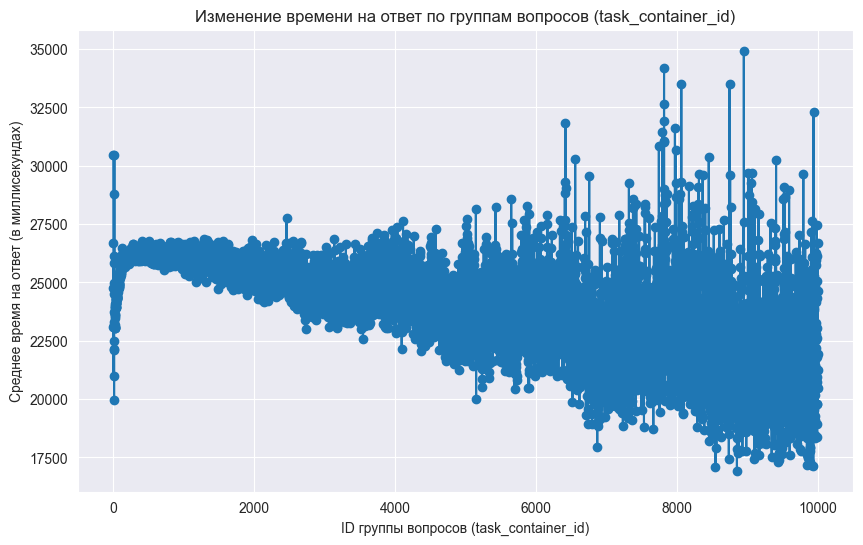

In [29]:
# 1. Фильтрация данных: оставляем только вопросы
questions_only = train[train['content_type_id'] == 0].copy()

# 2. Отфильтруем строки с пропусками в prior_question_elapsed_time
filtered_questions = questions_only.dropna(subset=['prior_question_elapsed_time'])

# 3. Группировка по task_container_id и вычисление среднего времени ответа для каждой группы
avg_time_by_group = filtered_questions.groupby('task_container_id')['prior_question_elapsed_time'].mean()

# 4. Построение графика изменения среднего времени на ответ для каждой группы вопросов
plt.figure(figsize=(10, 6))
plt.plot(avg_time_by_group.index, avg_time_by_group.values, marker='o')
plt.title('Изменение времени на ответ по группам вопросов (task_container_id)')
plt.xlabel('ID группы вопросов (task_container_id)')
plt.ylabel('Среднее время на ответ (в миллисекундах)')
plt.grid(True)
plt.show()

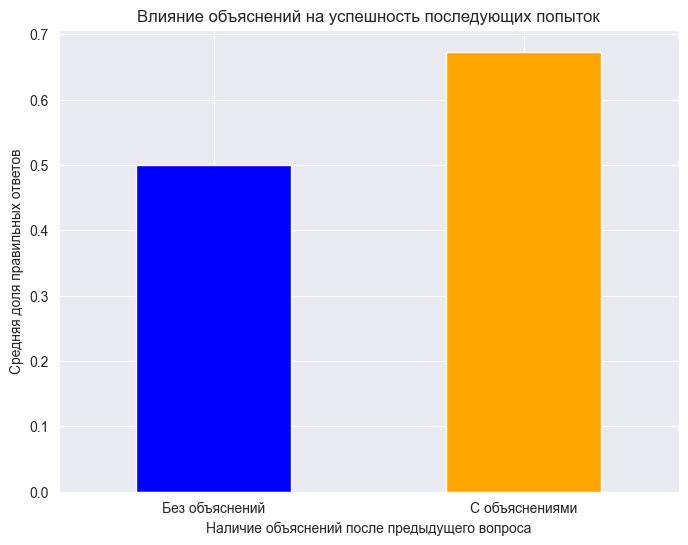

In [30]:
# 1. Фильтрация данных: оставляем только вопросы
questions_only = train[train['content_type_id'] == 0].copy()

# 2. Отфильтруем строки с пропусками в prior_question_had_explanation
filtered_questions = questions_only.dropna(subset=['prior_question_had_explanation'])

# 3. Группировка по наличию объяснений и расчет средней доли правильных ответов
performance_by_explanation = filtered_questions.groupby('prior_question_had_explanation')['answered_correctly'].mean()

# 4. Построение столбчатого графика для сравнения доли правильных ответов с объяснением и без
plt.figure(figsize=(8, 6))
performance_by_explanation.plot(kind='bar', color=['blue', 'orange'])
plt.title('Влияние объяснений на успешность последующих попыток')
plt.xlabel('Наличие объяснений после предыдущего вопроса')
plt.ylabel('Средняя доля правильных ответов')
plt.xticks([0, 1], ['Без объяснений', 'С объяснениями'], rotation=0)
plt.grid(True)
plt.show()

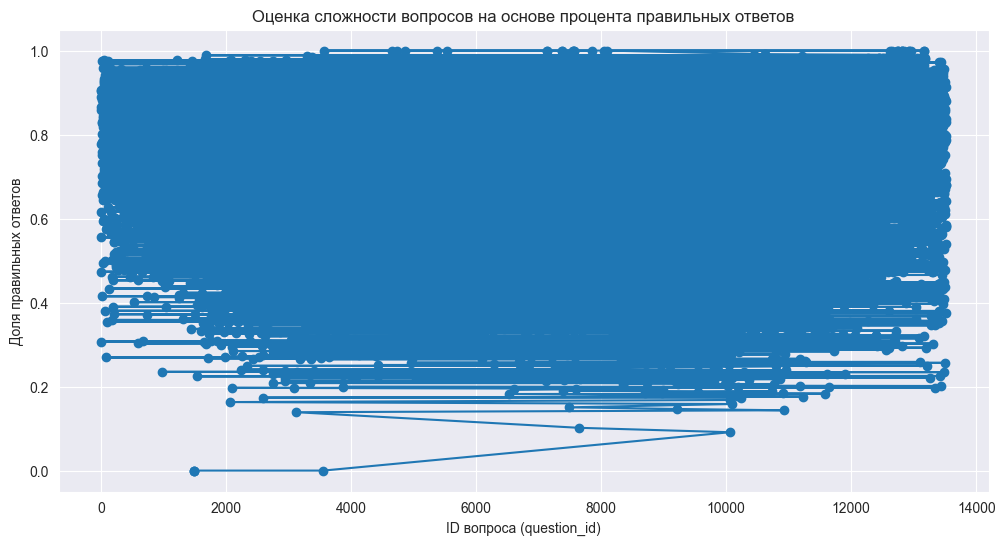

In [31]:
# 1. Фильтрация данных: оставляем только вопросы
questions_only = train[train['content_type_id'] == 0].copy()

# 2. Группировка по question_id и расчет доли правильных ответов для каждого вопроса
difficulty_by_question = questions_only.groupby('content_id')['answered_correctly'].mean().reset_index()

# 3. Сортировка по проценту правильных ответов
difficulty_by_question = difficulty_by_question.sort_values(by='answered_correctly')

# 4. Построение графика распределения сложности вопросов
plt.figure(figsize=(12, 6))
plt.plot(difficulty_by_question['content_id'], difficulty_by_question['answered_correctly'], marker='o', linestyle='-')
plt.title('Оценка сложности вопросов на основе процента правильных ответов')
plt.xlabel('ID вопроса (question_id)')
plt.ylabel('Доля правильных ответов')
plt.grid(True)
plt.show()

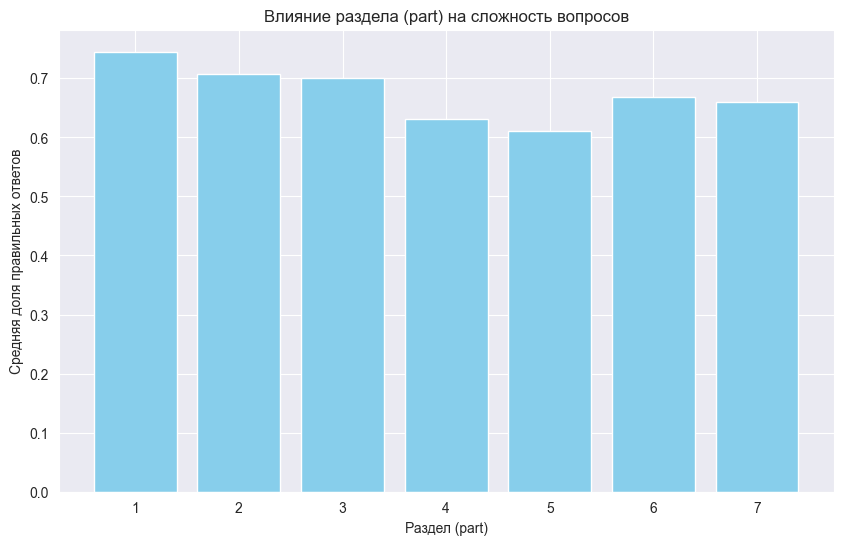

In [32]:
# 1. Объединение train.csv с questions.csv по полю content_id
merged_data = pd.merge(train[train['content_type_id'] == 0], questions, left_on='content_id', right_on='question_id')

# 2. Группировка данных по разделу (part) и расчет средней доли правильных ответов
performance_by_part = merged_data.groupby('part')['answered_correctly'].mean().reset_index()

# 3. Построение графика для анализа влияния раздела на сложность
plt.figure(figsize=(10, 6))
plt.bar(performance_by_part['part'], performance_by_part['answered_correctly'], color='skyblue')
plt.title('Влияние раздела (part) на сложность вопросов')
plt.xlabel('Раздел (part)')
plt.ylabel('Средняя доля правильных ответов')
plt.grid(True)
plt.show()

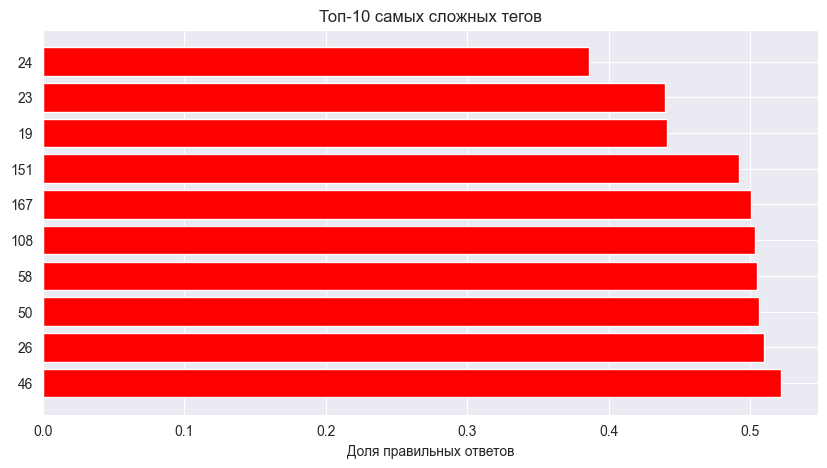

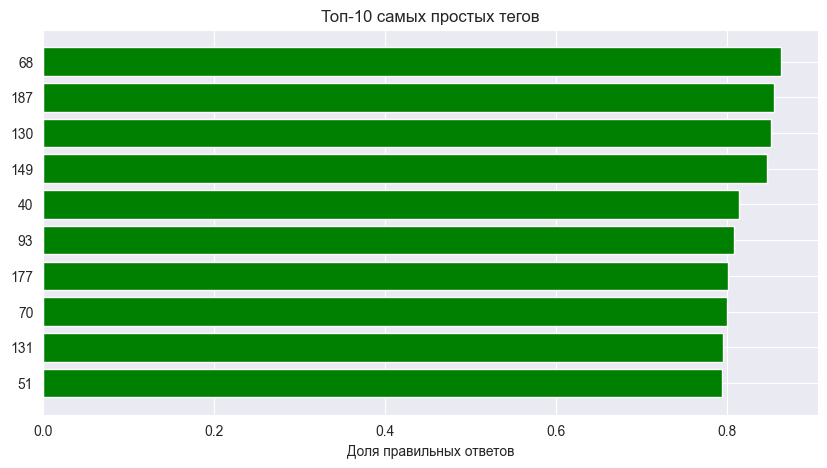

In [33]:
# 2. Разделим теги по пробелам, чтобы каждый тег стал отдельной записью
merged_data['tags_split'] = merged_data['tags'].str.split(' ')

# 3. Создаем отдельную строку для каждого тега
exploded_tags = merged_data.explode('tags_split')

# 4. Группировка по тегам и расчет средней доли правильных ответов
performance_by_tag = exploded_tags.groupby('tags_split')['answered_correctly'].mean().reset_index()

# 5. Сортировка для поиска топ-10 самых сложных и самых простых тегов
top_10_hardest_tags = performance_by_tag.sort_values(by='answered_correctly').head(10)
top_10_easiest_tags = performance_by_tag.sort_values(by='answered_correctly', ascending=False).head(10)

# 6. Построение графиков

# График самых сложных тегов
plt.figure(figsize=(10, 5))
plt.barh(top_10_hardest_tags['tags_split'], top_10_hardest_tags['answered_correctly'], color='red')
plt.xlabel('Доля правильных ответов')
plt.title('Топ-10 самых сложных тегов')
plt.gca().invert_yaxis()  # Инвертируем ось Y, чтобы самые сложные были сверху
plt.grid(True)
plt.show()

# График самых простых тегов
plt.figure(figsize=(10, 5))
plt.barh(top_10_easiest_tags['tags_split'], top_10_easiest_tags['answered_correctly'], color='green')
plt.xlabel('Доля правильных ответов')
plt.title('Топ-10 самых простых тегов')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

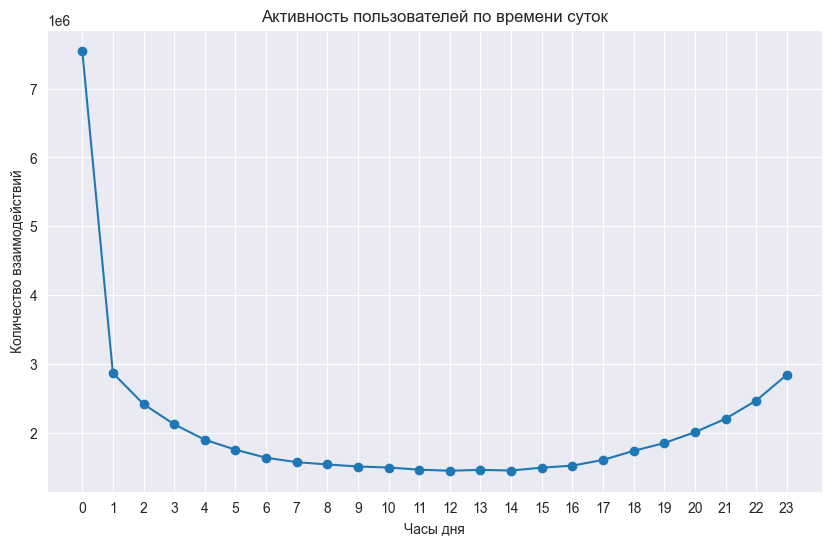

In [34]:
# Преобразование timestamp в часы дня
train['hour_of_day'] = (train['timestamp'] // (1000 * 60 * 60)) % 24

# Группировка по часам и подсчет количества взаимодействий в каждый час
activity_by_hour = train.groupby('hour_of_day').size().reset_index(name='interaction_count')

# Построение графика активности пользователей по часам
plt.figure(figsize=(10, 6))
plt.plot(activity_by_hour['hour_of_day'], activity_by_hour['interaction_count'], marker='o')
plt.title('Активность пользователей по времени суток')
plt.xlabel('Часы дня')
plt.ylabel('Количество взаимодействий')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

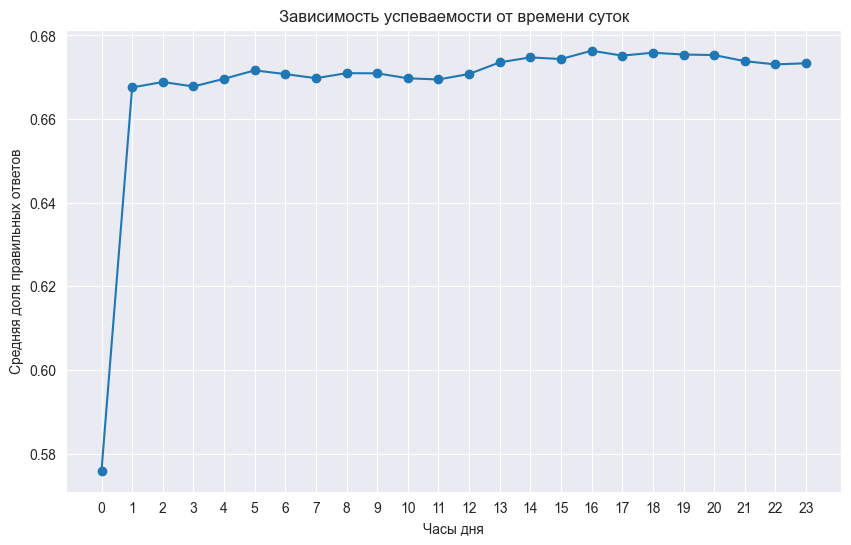

In [35]:
# Преобразование timestamp в часы дня
train['hour_of_day'] = (train['timestamp'] // (1000 * 60 * 60)) % 24

# Фильтрация данных: оставляем только вопросы
questions_only = train[train['content_type_id'] == 0]

# Группировка по часам дня и расчет средней доли правильных ответов
performance_by_hour = questions_only.groupby('hour_of_day')['answered_correctly'].mean().reset_index()

# Построение графика зависимости успеваемости от времени суток
plt.figure(figsize=(10, 6))
plt.plot(performance_by_hour['hour_of_day'], performance_by_hour['answered_correctly'], marker='o')
plt.title('Зависимость успеваемости от времени суток')
plt.xlabel('Часы дня')
plt.ylabel('Средняя доля правильных ответов')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

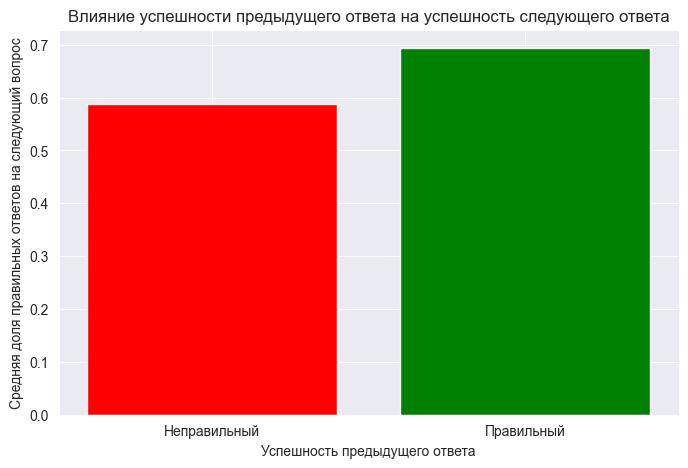

In [36]:
# 1. Фильтрация данных: оставляем только вопросы
questions_only = train[train['content_type_id'] == 0].copy()

# 2. Сортировка данных по пользователю и времени
questions_only = questions_only.sort_values(by=['user_id', 'timestamp'])

# 3. Создание сдвинутой колонки, которая показывает успешность предыдущего ответа для каждого пользователя
questions_only['previous_answered_correctly'] = questions_only.groupby('user_id')['answered_correctly'].shift(1)

# 4. Удаление первой строки для каждого пользователя, так как у них нет предыдущего ответа
questions_only = questions_only.dropna(subset=['previous_answered_correctly'])

# 5. Группировка по предыдущему ответу и расчет средней доли правильных ответов на следующий вопрос
performance_by_previous = questions_only.groupby('previous_answered_correctly')['answered_correctly'].mean().reset_index()

# 6. Построение графика
plt.figure(figsize=(8, 5))
plt.bar(performance_by_previous['previous_answered_correctly'].astype(str), performance_by_previous['answered_correctly'], color=['red', 'green'])
plt.title('Влияние успешности предыдущего ответа на успешность следующего ответа')
plt.xlabel('Успешность предыдущего ответа')
plt.ylabel('Средняя доля правильных ответов на следующий вопрос')
plt.xticks([0, 1], ['Неправильный', 'Правильный'])
plt.grid(True)
plt.show()

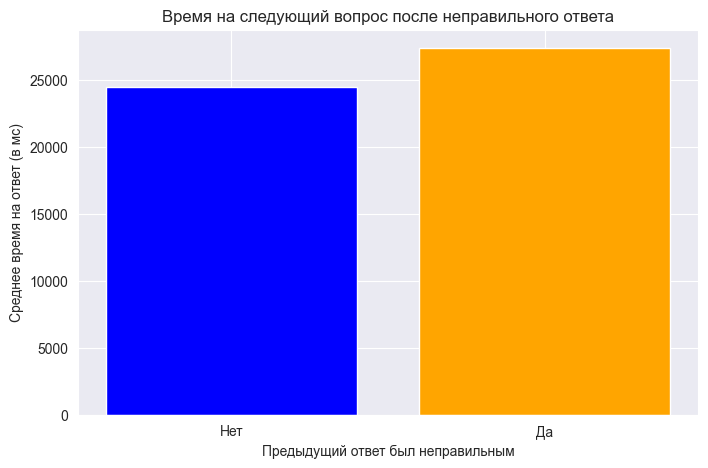

In [37]:
# 1. Фильтрация данных: оставляем только вопросы
questions_only = train[train['content_type_id'] == 0].copy()

# 2. Сортировка данных по пользователю и времени
questions_only = questions_only.sort_values(by=['user_id', 'timestamp'])

# 3. Создание колонки с информацией о том, был ли предыдущий ответ неправильным
questions_only['previous_answer_wrong'] = questions_only.groupby('user_id')['answered_correctly'].shift(1) == 0

# 4. Удаление первой строки для каждого пользователя, так как у них нет предыдущего ответа
questions_only = questions_only.dropna(subset=['previous_answer_wrong'])

# 5. Группировка по предыдущему ответу (правильный/неправильный) и расчет средней доли правильных ответов и среднего времени на следующий вопрос
behavior_after_wrong = questions_only.groupby('previous_answer_wrong').agg({
    'answered_correctly': 'mean',
    'prior_question_elapsed_time': 'mean'
}).reset_index()

# 6. Построение графика: среднее время на следующий вопрос после неправильного ответа
plt.figure(figsize=(8, 5))
plt.bar(behavior_after_wrong['previous_answer_wrong'].astype(str), behavior_after_wrong['prior_question_elapsed_time'], color=['blue', 'orange'])
plt.title('Время на следующий вопрос после неправильного ответа')
plt.xlabel('Предыдущий ответ был неправильным')
plt.ylabel('Среднее время на ответ (в мс)')
plt.xticks([0, 1], ['Нет', 'Да'])
plt.grid(True)
plt.show()

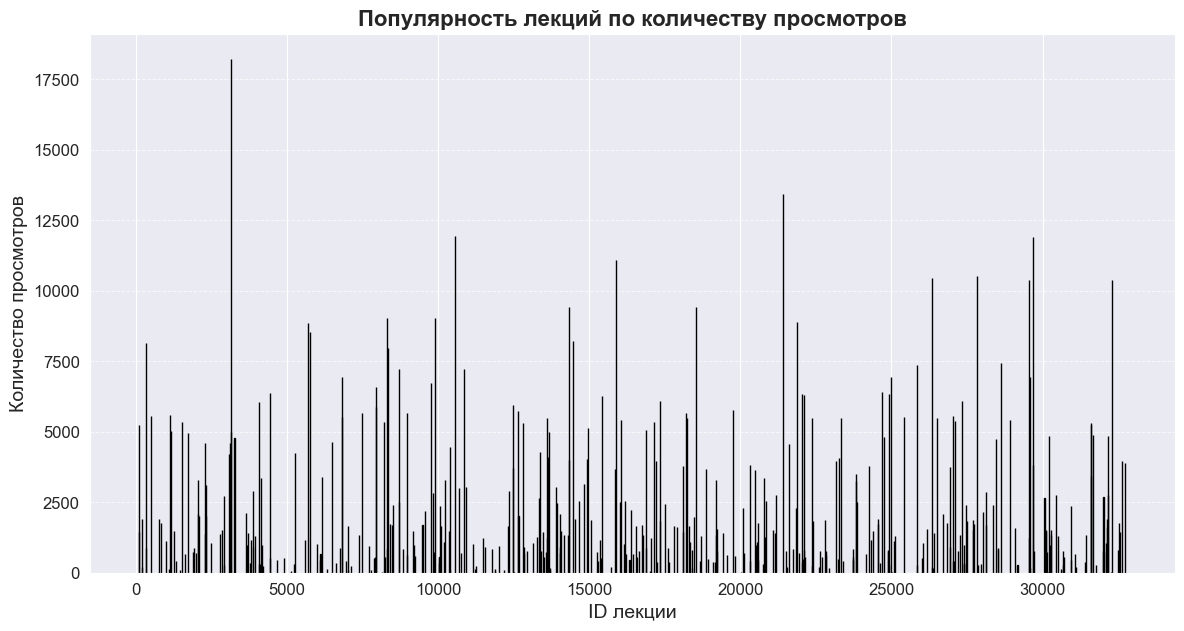

In [39]:
# 1. Фильтрация данных: оставляем только лекции (content_type_id == 1)
lectures_only = train[train['content_type_id'] == 1].copy()

# 2. Подсчет количества просмотров каждой лекции
lecture_popularity = lectures_only['content_id'].value_counts().reset_index()
lecture_popularity.columns = ['lecture_id', 'view_count']

# 3. Слияние с данными о лекциях для получения дополнительной информации
lecture_popularity = pd.merge(lecture_popularity, lectures, left_on='lecture_id', right_on='lecture_id')

# 4. Построение графика популярности лекций с улучшенной контрастностью
plt.figure(figsize=(14, 7))
plt.bar(lecture_popularity['lecture_id'], lecture_popularity['view_count'], color='darkblue', edgecolor='black')
plt.title('Популярность лекций по количеству просмотров', fontsize=16, fontweight='bold')
plt.xlabel('ID лекции', fontsize=14)
plt.ylabel('Количество просмотров', fontsize=14)
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

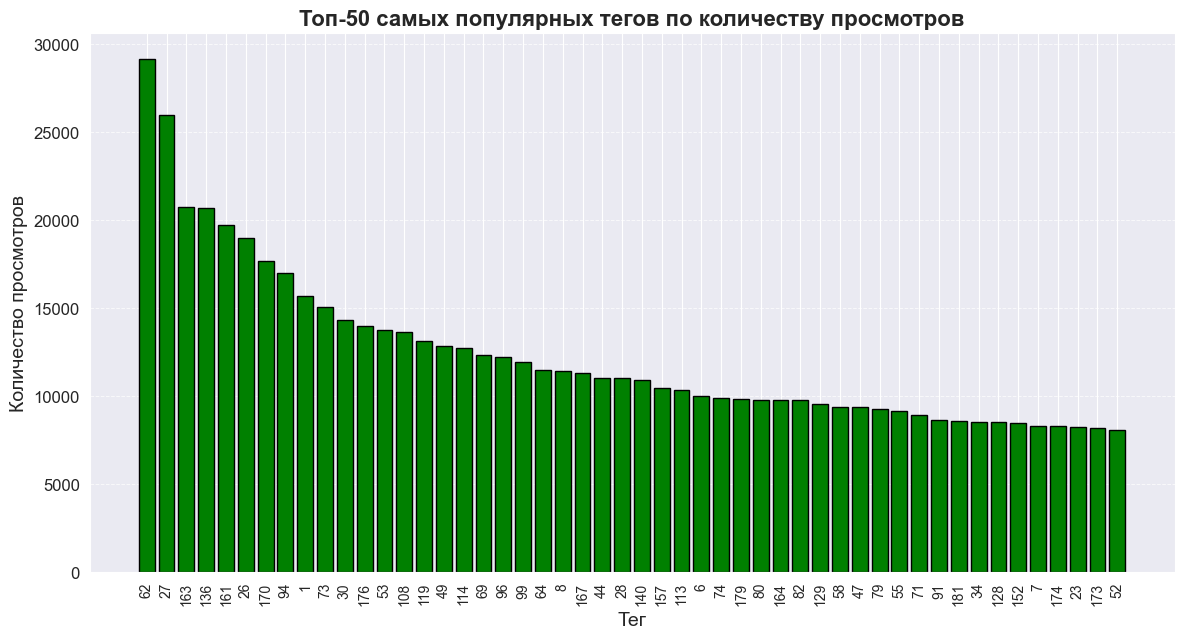

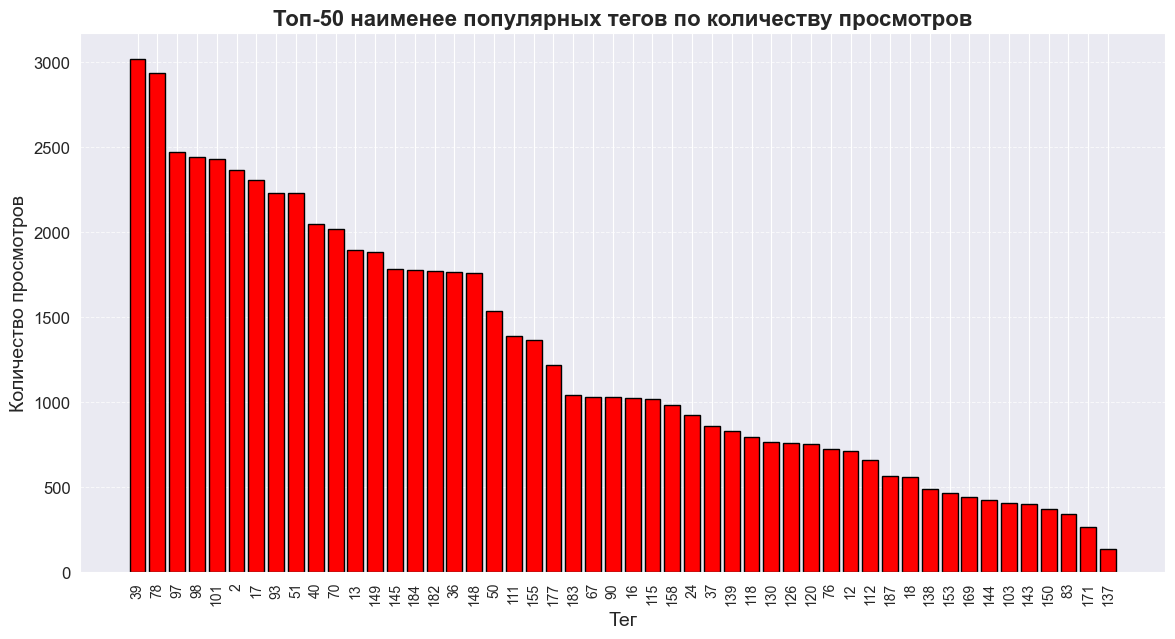

In [41]:
# 1. Фильтрация данных: оставляем только лекции
lectures_only = train[train['content_type_id'] == 1].copy()

# 2. Слияние с данными о лекциях для получения информации о тегах
lectures_with_tags = pd.merge(lectures_only, lectures, left_on='content_id', right_on='lecture_id')

# 3. Подсчет количества просмотров для каждого тега
tag_popularity = lectures_with_tags['tag'].value_counts().reset_index()
tag_popularity.columns = ['tag', 'view_count']

# 4. Сортировка для поиска топ-50 самых популярных и наименее популярных тегов
top_50_popular_tags = tag_popularity.head(50)
bottom_50_popular_tags = tag_popularity.tail(50)

# 5. Построение графиков

# График топ-50 самых популярных тегов
plt.figure(figsize=(14, 7))
plt.bar(top_50_popular_tags['tag'].astype(str), top_50_popular_tags['view_count'], color='green', edgecolor='black')
plt.title('Топ-50 самых популярных тегов по количеству просмотров', fontsize=16, fontweight='bold')
plt.xlabel('Тег', fontsize=14)
plt.ylabel('Количество просмотров', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.show()

# График топ-50 наименее популярных тегов
plt.figure(figsize=(14, 7))
plt.bar(bottom_50_popular_tags['tag'].astype(str), bottom_50_popular_tags['view_count'], color='red', edgecolor='black')
plt.title('Топ-50 наименее популярных тегов по количеству просмотров', fontsize=16, fontweight='bold')
plt.xlabel('Тег', fontsize=14)
plt.ylabel('Количество просмотров', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.show()